In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [20]:
dataset = pd.read_excel('../dataset/combined_svs.xlsx')

In [21]:
dataset = dataset[~dataset["Conformity"].isnull()]

In [22]:
Messages = dataset['Message']

In [23]:
Messages

0      I can morning. i'm Okay, how are you. that's a...
1      i'm doing good give me a. Second. yeah I can h...
2      morning. Barely good one are barely. that's al...
3      How are you. How. A lot a lot Oh, she got the ...
4      yeah I went to that page and I don't know what...
                             ...                        
107    Did you hear me now. GA release a great teams,...
108    i'm good. Seeing you. Ryan Robinson April 14 1...
109    No, I gotta go get him I didn't want me to cal...
110    hey. um I guess like I just can't get confused...
373    Back to work garbage. seven days a week, worki...
Name: Message, Length: 112, dtype: object

In [24]:
Traits = dataset.drop(columns=['Message','ID'])

In [25]:
Traits.head()

,Conservation,Conformity,Tradition,Security,Self-Transcendance,Benevolence,Universalism,Self-Enhancement,Power,Achievement,Stimulation,Openness to Change,Hedonism,Self-Direction
0,4.000000,3.0,1.0,8.0,8.0,8.0,8.0,3.0,3.0,3.0,1.0,4.333333,4.0,8.0
1,3.000000,3.0,3.0,3.0,5.0,6.0,4.0,5.0,4.0,6.0,4.0,4.000000,4.0,4.0
2,7.333333,6.0,8.0,8.0,6.5,8.0,5.0,6.5,5.0,8.0,8.0,7.666667,7.0,8.0
3,8.000000,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,6.333333,5.0,6.0
4,8.000000,8.0,8.0,8.0,8.0,8.0,8.0,4.5,1.0,8.0,8.0,8.000000,8.0,8.0


In [26]:
vectorizer = TfidfVectorizer(max_features=512)  # Use TF-IDF to convert text to embeddings
X = vectorizer.fit_transform(Messages)

In [27]:
X.shape

(112, 512)

In [28]:
y = Traits.values
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [29]:
def scale_back(scaler:MinMaxScaler,vector):
    return scaler.inverse_transform(vector.reshape(1,-1))

In [30]:
y.shape

(112, 14)

In [33]:
pca = PCA(n_components=14)
y_reduced = pca.fit_transform(y)

In [34]:
tuned_params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}
xgb_model = MultiOutputRegressor(XGBRegressor(**tuned_params))

In [35]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),          # Step 1: Text vectorization
    ('regressor', xgb_model)             # Step 2 & 3: Multi-output regression
])

In [36]:
pipeline.fit(Messages, y_reduced)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=512)),
                ('regressor',
                 MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eta=0.1,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...)))])

In [47]:
def predict_traits(id,input_text):
    y_pred_reduced = pipeline.predict([input_text])
    y_pred_full = pca.inverse_transform(y_pred_reduced)[0]
    y_pred_full = np.array([float(score) for score in y_pred_full])
    trait_names = list(Traits.columns) + ['ID','Message']
    trait_dict = dict(zip(trait_names, [round(float(trait),4) for trait in scale_back(scaler,y_pred_full)[0]] +[id,input_text] ))
    return trait_dict,scale_back(scaler,y_pred_full)

In [39]:
scores = []
output = []
for index,row in dataset.iterrows():
    input_text = row['Message']
    predicted_traits,y_out = predict_traits(row['ID'],input_text)
    # score = r2_score(scale_back(scaler,y[index])[0],y_out[0])
    # scores.append(score)
    output.append(predicted_traits)

In [ ]:
pd.DataFrame(output).to_excel('../dataset/NewOutputsScaled_svs.xlsx',index=False)

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

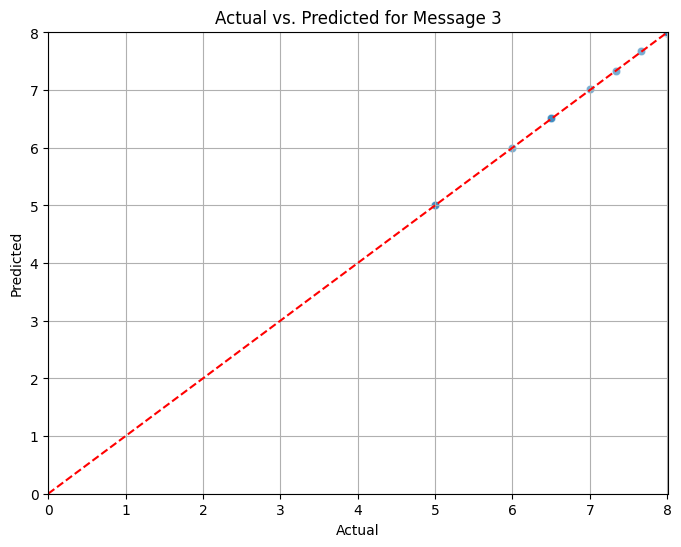

In [48]:
trait_index = 2
input = Messages[trait_index]
predicted_traits,y_out = predict_traits(0,input)

df = pd.DataFrame({
    'Actual': scale_back(scaler,y[trait_index])[0],
    'Predicted': y_out[0]
})

# Create the scatter plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Actual', y='Predicted', alpha=0.6)

# Add a line for perfect prediction
max_value = max(df['Actual'].max(), df['Predicted'].max())
plt.plot([0, max_value], [0, max_value], 'r--')  # Line for perfect prediction

plt.title(f'Actual vs. Predicted for Message {trait_index + 1}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid(True)
plt.show()

In [ ]:
import joblib
joblib.dump(pipeline, '../model/svs_pipeline.pkl')


['svs_pipeline.pkl']